# Introduction

>* Hello, our names are Vincent and J. Vincent Shorter

## Project Objective 
>* This project runs through the entire Data Science Pipeline and culminates with classification modelling techniques based upon Natural Langauge Processing outcomes.
>* This is a project attempting to construct a ML model to predict a github repository coding language based on just the project README file. 

## Executive Summary


>* Analysis of the data showed that unemployment rates are fairly small across most population groups


# Import Section

In [ ]:
import pandas as pd
import model
import wrangle

from importlib import reload
reload(model)

import warnings
warnings.filterwarnings("ignore")

# Wrangle (Acquire and Prep)
> * 

### Nulls/Missing Values
> * 
---
### Feature Engineering 
> * Engineered `word_count` in order to facilitate analysis around column length and unique word density
> * 
---   
### Flattening
> * Had to make decisions in order to remove optionality from language column due to sample size 
> - Went from around 17 languages down to 7 by creating an `other` category for the less popular langauges
> * Decisons here driven mostly by desire to have enough observations for effective analysis 
---


## Exploration Questions 
* Includes visualizations and statistical tests
* Primarily focused on items that appear on the typical resume or job application

In [ ]:
#calling prepare/acquire functions from module to acquire and split data subsets
df = wrangle.prep_aug()
train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle.split_scale(df, 'y')

### Spotlight - Commong Words 
* **Question:** What are the most common words in READMEs?
* **Answer:** 

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between industry of typical employment and employment status   
>* ${H_a}$: There is a relationship between industry of typical employment and employment status  
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 157.9437
p: 0.0000
degrees of freedom: 13
Reject null hypothesis


<Figure size 1440x432 with 0 Axes>

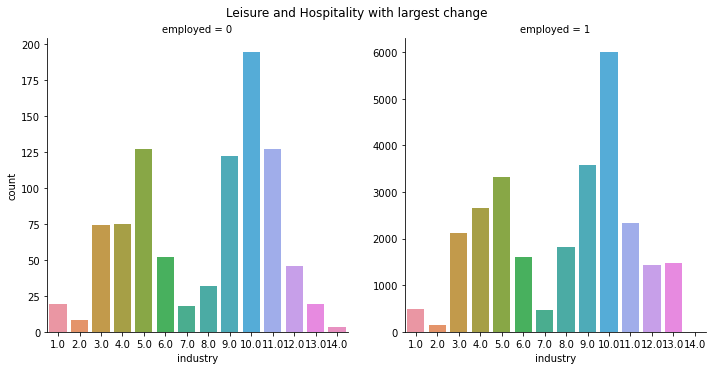

population_proportions                   unemployment_rate
                       employed unemployed change                  
industry                                                           
14.0                        NaN      0.003    NaN              1.00
11.0                      0.085      0.139 -0.054              0.05
2.0                       0.005      0.009 -0.003              0.05
1.0                       0.018      0.021 -0.003              0.04
7.0                       0.017      0.020 -0.003              0.04
5.0                       0.121      0.139 -0.017              0.04
3.0                       0.077      0.081 -0.003              0.03
9.0                       0.130      0.133 -0.003              0.03
6.0                       0.058      0.057  0.001              0.03
10.0                      0.219      0.212  0.007              0.03
12.0                      0.052      0.050  0.002              0.03
4.0                       0.097      0.082  0.015              0.03
8.0                       0.067      0.035  0.032              0.02
13.0                      0.054      0.021  0.033              0.01

In [ ]:
#calls function to display visuals and results of statistical analysis and testing
model.spotlight_stats(train, 'industry', 'Leisure and Hospitality with largest change')

1	Agriculture, forestry, fishing, and hunting		
	
2	Mining		

3	Construction  	

4	Manufacturing  			

5	Wholesale and retail trade	  

6	Transportation and utilities	 

7	Information	  			

8	Financial activities	  	

9	Professional and business services	  	

10	Educational and health services		

11	Leisure and hospitality	  		

12	Other services		  			

13	Public administration	  		
					
14	Armed Forces  

### Spotlight - README Length
* **Question:** Does the length of the README vary by programming language?

* **Answer:** Indivduals identifying as White show the largest population proportion change with a drop of nearly 10% when comparing employed vs unemployed. Those identifying as mixed race other than with white, and Indigenous have the highest unemployed rates at 12% and 7% respectively. 

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `race` and `employment` status   
>* ${H_a}$: There is a relationship between `race` and `employment` status   
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 62.1129
p: 0.0000
degrees of freedom: 6
Reject null hypothesis


<Figure size 1440x432 with 0 Axes>

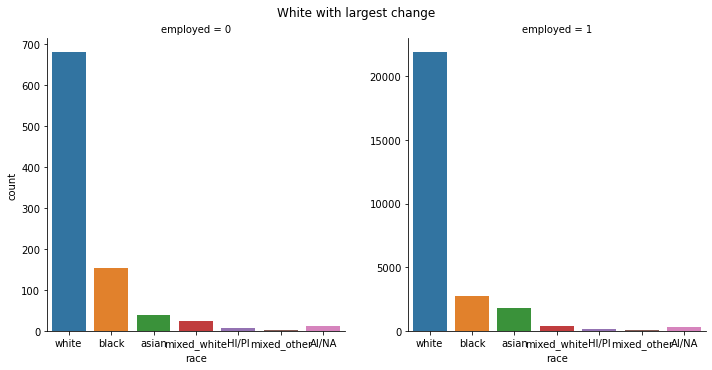

population_proportions                   unemployment_rate
                          employed unemployed change                  
race                                                                  
mixed_white                  0.015      0.026 -0.011              0.05
black                        0.099      0.168 -0.069              0.05
HI/PI                        0.005      0.008 -0.002              0.04
AI/NA                        0.011      0.014 -0.003              0.04
white                        0.799      0.741  0.058              0.03
asian                        0.066      0.041  0.024              0.02
mixed_other                  0.003      0.001  0.002              0.01

In [ ]:
#calls function to display visuals and results of statistical analysis and testing
model.spotlight_stats(train, 'race', 'White with largest change')

### Spotlight - Unique Words
* **Question:** Do different programming languages use a different number of unique words?
 
* **Answer:** 

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between having a `professional_certification` and `employment`  
>* ${H_a}$: There is a relationship between having a `professional_certification` and `employment`    
>* ${\alpha}$: .05
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 40.1235
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


<Figure size 1440x432 with 0 Axes>

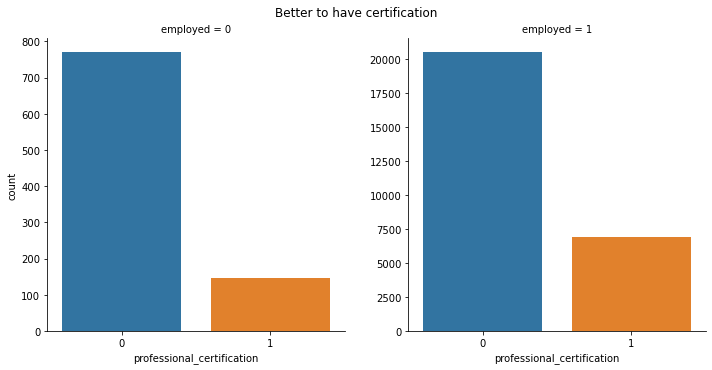

population_proportions                    \
                                         employed unemployed change   
professional_certification                                            
0                                           0.748      0.841 -0.093   
1                                           0.252      0.159  0.093   

                           unemployment_rate  
                                              
professional_certification                    
0                                       0.04  
1                                       0.02

In [ ]:
#calls function to display visuals and results of statistical analysis and testing
model.spotlight_stats(train, 'professional_certification', 'Better to have certification')

### Spotlight - Language ID by Word
* **Question:** Are there any words that uniquely identify a programming language?
 
* **Answer:** 

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between having a `professional_certification` and `employment`  
>* ${H_a}$: There is a relationship between having a `professional_certification` and `employment`    
>* ${\alpha}$: .05
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 40.1235
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


<Figure size 1440x432 with 0 Axes>

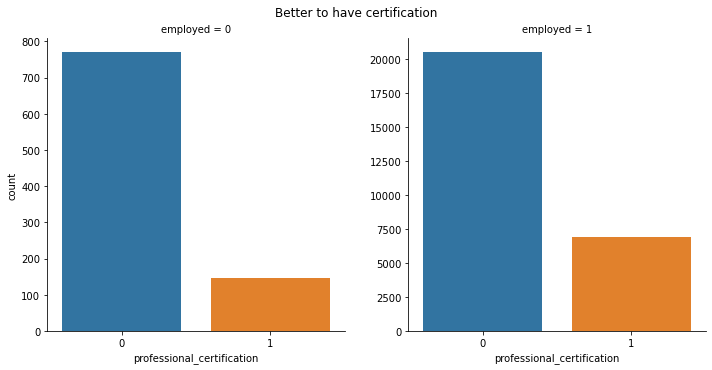

population_proportions                    \
                                         employed unemployed change   
professional_certification                                            
0                                           0.748      0.841 -0.093   
1                                           0.252      0.159  0.093   

                           unemployment_rate  
                                              
professional_certification                    
0                                       0.04  
1                                       0.02

In [ ]:
#calls function to display visuals and results of statistical analysis and testing
model.spotlight_stats(train, 'professional_certification', 'Better to have certification')

## Exploration Summary
* 

# Modeling
* Models process was initially guided by Accuracy due to multi-class nature of problem

* Initial testing seemed promising as models were performing well above the `27%` baseline prediction on the train subset

* Validation set performance was terrible, and caused a necessary rewrite of our acquire py. 

* 

## Features for Modeling
* Grouped by simple features: `word_count`, `lemmatized`

* `word_count`
    - Chosen to highlight the business oriented concerns around employement
    ---
* `lemmatized`
    - Highlights family and environment characteristics
    ---


## Top Models

## Validate
* Exposed Top 5 models from train section to the Validate data
* DTC models maintained highest performance profile througout all testing cohorts
* Model:
* Model:
    - Name: LR_56
    - Type: Logistic Regression
    - C: `.5`
    - Solver: `newton-cg`
    - Weight: `balanced`    
    - Features: ``
* Model:
    - Name: LR_36
    - Type: Logistic Regression
    - C: `.1`
    - Solver: `lbfgs`
    - Weight: `balanced`
    - Features: `word_count`, `lemmatized`
* Model:
    - Name: LR_36
    - Type: Logistic Regression
    - C: `.1`
    - Solver: `lbfgs`
    - Weight: `balanced`
    - Features: `word_count`, `lemmatized`
* Model:
    - Name: LR_36
    - Type: Logistic Regression
    - C: `.1`
    - Solver: `lbfgs`
    - Weight: `balanced`
    - Features: `word_count`, `lemmatized`

## Test
* Best Performing Model:
    - Name: LR_16
    - Type: Logistic Regression
    - C: `.1`
    - Solver: `lbfgs`
    - Weight: `balanced`
    - Features: `household_num`, `children_in_household`, `education`, `enrolled_in_school`, `family_income`, `marital_status`

# Conclusion
## Summary of Key Findings
>* 
---
## Suggestions and Next Steps
>* 
